In [1]:
import numpy as np
import math
import time
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display,Image,HTML
from z3 import *
from collections import defaultdict

### Solution as published 
https://www.janestreet.com/puzzles/split-division-2-index/

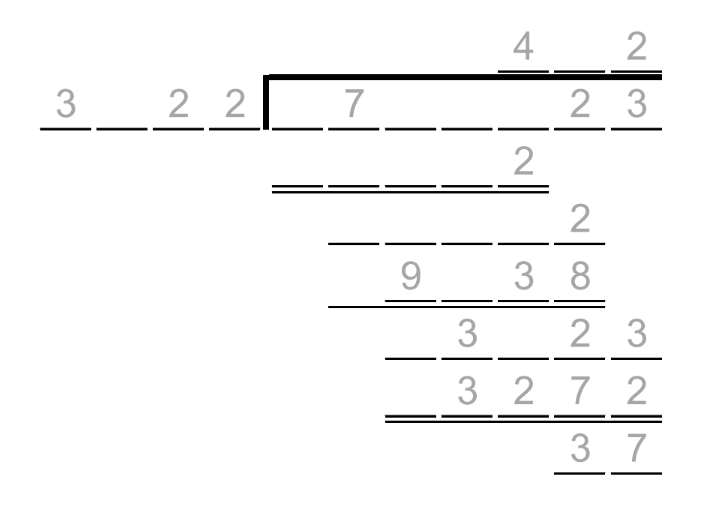

In [2]:
url='https://www.janestreet.com/puzzles/split-division-2-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/2021-11-01-split-division-2.png',width=300))
HTML(str(soup.find_all('div', {'class' :'inner-wrapper'})[1]))

In [3]:
# set up the constraints given by the GCDs 
def constrain(x,y,c):
    if c>0:
        return Or([And(x==i,y==j) for i in range(10) for j in range(10) if math.gcd(i,j)==c])
    else:
        return And(x>=0, x<=9, y>=0, y<=9,
                  And([Implies(x==d,And([y!=i for i in range(2,10) if math.gcd(d,i) > 1])) for d in range(2,10)]),
                  And([Implies(y==d,And([x!=i for i in range(2,10) if math.gcd(d,i) > 1])) for d in range(2,10)])
                  )    

In [4]:
start = time.time()

# set up the variables and the solver
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
names = ["divisor","dividend","quotient","row1","row2","row3","row4","row5","row6"]
lengths = [4,7,3,5,5,4,5,5,2]

s = Tactic("qffd").solver()

for n in range(len(names)):
    locals()["A"+names[n]] = IntVector("A"+names[n],lengths[n])
    locals()["B"+names[n]] = IntVector("B"+names[n],lengths[n])
    s += [And(e>=0,e<=9) for e in eval("A"+names[n])]
    s += [And(e>=0,e<=9) for e in eval("B"+names[n])]

# The Constraints
# ~~~~~~~~~~~~~~~
Cdivisor = [3,0,2,2]
Cdividend = [0,7,0,0,0,2,3]
Cquotient = [4,0,2]
Crow1 = [0,0,0,0,2]
Crow2 = [0,0,0,0,2]
Crow3 = [9,0,3,8]
Crow4 = [0,3,0,2,3]
Crow5 = [0,3,2,7,2]
Crow6 = [3,7]

for i in range(len(names)):
    for j in range(len(eval("A"+names[i]))):
        s += constrain(eval("A"+names[i])[j],eval("B"+names[i])[j],eval("C"+names[i])[j])

v =["A","B"]        
        
# the long division elements
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
for i in v:
    locals()[i+"initial"]= eval(i+"dividend")[:-2]
    locals()[i+"remainder1"] = eval(i+"row2")[:-1]
    locals()[i+"remainder2"] = eval(i+"row4")[:-1]

# function to convert from list to number
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num = lambda x: Sum([x[-(i+1)] * (10**i) for i in range(len(x))])

# line by line
# ~~~~~~~~~~~~
# the first quotient
s += [num(eval(i+"row1")) == num(eval(i+"divisor")) * eval(i+"quotient")[0] for i in v]
s += [num(eval(i+"initial")) - num(eval(i+"row1")) == num(eval(i+"remainder1")) for i in v]

# the second quotient
s += [num(eval(i+"row2")) == num(eval(i+"remainder1")) * 10 + eval(i+"dividend")[5] for i in v]
s += [num(eval(i+"row3")) == num(eval(i+"divisor")) * eval(i+"quotient")[1] for i in v]
s += [num(eval(i+"row2")) - num(eval(i+"row3")) == num(eval(i+"remainder2")) for i in v]

# the third quotient
s += [num(eval(i+"row4")) == num(eval(i+"remainder2")) * 10 + eval(i+"dividend")[6] for i in v]
s += [num(eval(i+"row5")) == num(eval(i+"divisor")) * eval(i+"quotient")[2] for i in v]
s += [num(eval(i+"row4")) - num(eval(i+"row5")) == num(eval(i+"row6")) for i in v]

# no leading zeros
s += And([eval(i+j)[0] != 0 for i in v for j in names])

# overall
s +=  [num(eval(i+"dividend")) == num(eval(i+"divisor")) * num(eval(i+"quotient")) + num(eval(i+"row6")) for i in v]

print("Setup took {:,.2f} seconds".format(time.time()-start))

Setup took 0.24 seconds


In [5]:
# Solve and Display
# ~~~~~~~~~~~~~~~~~
start = time.time()
if s.check() == sat:
    m = s.model()
    print("Solved in {:,.2f} seconds".format(time.time()-start))
    
    #calculate functions
    evalu = np.vectorize(lambda x :m.evaluate(x).as_long())
    eval_num = lambda x :int("".join(str(i) for i in evalu(x)))                    
    
    a_result = [eval_num(eval("A"+i)) for i in names]
    b_result = [eval_num(eval("B"+i)) for i in names]                    
                        
    print("\n{:,.0f} / {:,.0f} = {:,.0f} remainder {}\n".format(a_result[1],a_result[0],a_result[2],a_result[-1]))
    for x in range(1,7):
        print("row{}: {:,.0f}".format(x,a_result[2+x]))           
    
    print("\n{:,.0f} / {:,.0f} = {:,.0f} remainder {}\n".format(b_result[1],b_result[0],b_result[2],b_result[-1]))    
    for x in range(1,7):
        print("row{}: {:,.0f}".format(x,b_result[2+x]))
    
    print("\nSolution is: {:,.0f}".format(a_result[1]+b_result[1]))
                    
else:
    print("Failed")

Solved in 0.74 seconds

2,713,723 / 3,246 = 836 remainder 67

row1: 25,968
row2: 11,692
row3: 9,738
row4: 19,543
row5: 19,476
row6: 67

3,754,249 / 9,068 = 414 remainder 97

row1: 36,272
row2: 12,704
row3: 9,068
row4: 36,369
row5: 36,272
row6: 97

Solution is: 6,467,972


### Solution as published 
https://www.janestreet.com/puzzles/split-division-2-solution/

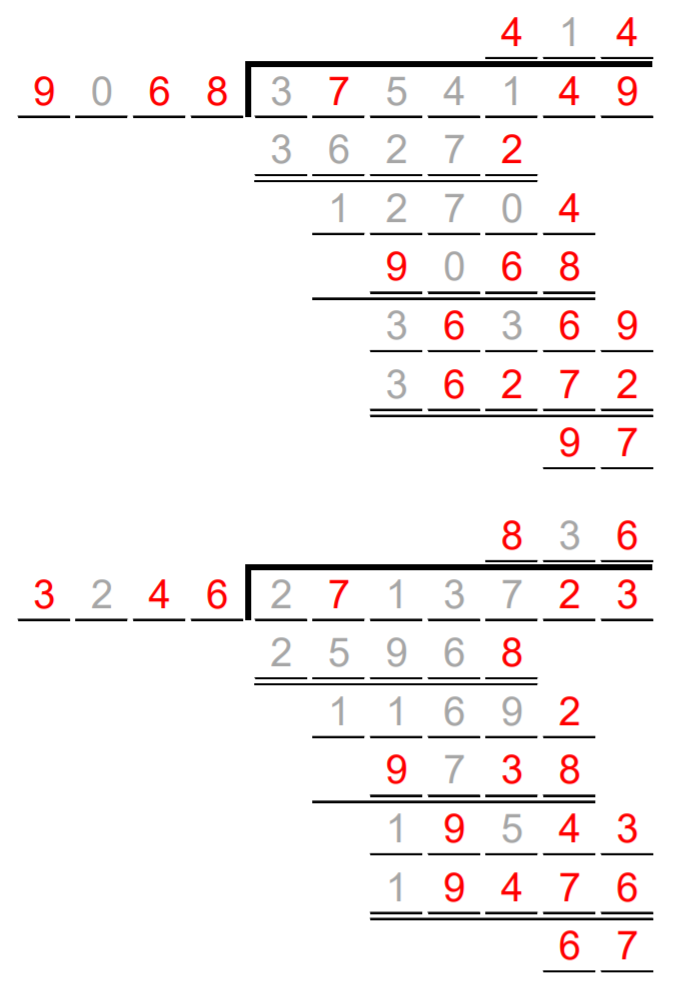

In [6]:
url='https://www.janestreet.com/puzzles/split-division-2-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/2021-11-01-split-division-2-solution.png',width=300))
HTML(str(soup.find_all('div', {'class' :'inner-wrapper'})[1]))